<a href="https://colab.research.google.com/github/bam098/plant_pathology/blob/main/plant_pathology_resnet50_300px_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plant Pathology
[Kaggle link](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data)

Based on- https://github.com/bam098/plant_pathology/blob/main/bam098_plant_pathology_v8_cln.ipynb

### Install, Imports, Download, and Random Seed

In [1]:
! pip uninstall fastai -y
! pip install fastai

Uninstalling fastai-2.1.8:
  Successfully uninstalled fastai-2.1.8
  Using cached https://files.pythonhosted.org/packages/ff/53/da994550c0dd2962351fd694694e553afe0c9516c02251586790f830430b/fastai-2.1.8-py3-none-any.whl


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import platform
import fastai
from fastai.vision.all import *
import sklearn
from sklearn.metrics import roc_auc_score
import torch
import torchvision
import pandas as pd

In [3]:
print('python version:      {}'.format(platform.python_version()))
print('fastai version:      {}'.format(fastai.__version__))
print('sklearn version:     {}'.format(sklearn.__version__))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('pandas version:      {}'.format(pd.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
fastai version:      2.1.8
sklearn version:     0.22.2.post1
torch version:       1.7.0+cu101
torchvision version: 0.8.1+cu101
pandas version:      1.1.5
CUDA available:      True
cuDNN enabled:       True
num gpus:            1
gpu:                 Tesla T4

------------------------- CUDA -------------------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [4]:
random_seed = 42

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
data_dir = Path('/content/drive/MyDrive/Kaggle/plant_pathology')
img_dir = data_dir / 'images'

img_size = 300
bs = 25
arch = resnet50
lr = 1e-2

In [5]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

### Data

In [6]:
data_dir.ls()

(#7) [Path('/content/drive/MyDrive/Kaggle/plant_pathology/test.csv'),Path('/content/drive/MyDrive/Kaggle/plant_pathology/sample_submission.csv'),Path('/content/drive/MyDrive/Kaggle/plant_pathology/train.csv'),Path('/content/drive/MyDrive/Kaggle/plant_pathology/images'),Path('/content/drive/MyDrive/Kaggle/plant_pathology/.ipynb_checkpoints'),Path('/content/drive/MyDrive/Kaggle/plant_pathology/stage-1.pth'),Path('/content/drive/MyDrive/Kaggle/plant_pathology/stage-2.pth')]

In [7]:
img_dir.ls()

(#3642) [Path('/content/drive/MyDrive/Kaggle/plant_pathology/images/Train_558.jpg'),Path('/content/drive/MyDrive/Kaggle/plant_pathology/images/Train_578.jpg'),Path('/content/drive/MyDrive/Kaggle/plant_pathology/images/Train_585.jpg'),Path('/content/drive/MyDrive/Kaggle/plant_pathology/images/Train_555.jpg'),Path('/content/drive/MyDrive/Kaggle/plant_pathology/images/Train_540.jpg'),Path('/content/drive/MyDrive/Kaggle/plant_pathology/images/Train_588.jpg'),Path('/content/drive/MyDrive/Kaggle/plant_pathology/images/Train_536.jpg'),Path('/content/drive/MyDrive/Kaggle/plant_pathology/images/Train_594.jpg'),Path('/content/drive/MyDrive/Kaggle/plant_pathology/images/Train_581.jpg'),Path('/content/drive/MyDrive/Kaggle/plant_pathology/images/Train_549.jpg')...]

### EDA

In [8]:
train_df = pd.read_csv(data_dir/'train.csv')
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [9]:
train_df.shape

(1821, 5)

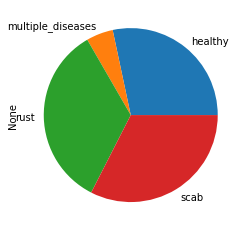

In [10]:
train_df[labels].sum().plot(kind='pie')

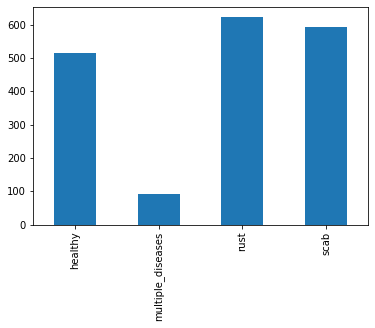

In [11]:
train_df[labels].sum().plot(kind='bar')

### Data Loading

In [12]:
train_df['label'] = train_df[labels].idxmax(axis=1)
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [13]:
train_df['label'].value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64

In [14]:
# oversampling, ref: https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763

train_df_bal = pd.concat(
    [train_df.query('label != "multiple_diseases"'), train_df] +
    [train_df.query('label == "multiple_diseases"')] * 2
).sample(frac=1.0, random_state=random_seed).reset_index(drop=True)

In [15]:
train_df_bal['label'].value_counts()

rust                 1244
scab                 1184
healthy              1032
multiple_diseases     273
Name: label, dtype: int64

In [22]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock()),
    getters=[ColReader('image_id',
                       pref=img_dir,
                       suff='.jpg'), ColReader('label')],
    splitter=RandomSplitter(valid_pct=0.2, seed=random_seed),
    item_tfms=RandomResizedCrop(img_size, min_scale=0.6),
    batch_tfms=aug_transforms(mult=2)
)

In [23]:
dls = db.dataloaders(train_df_bal, bs=bs)

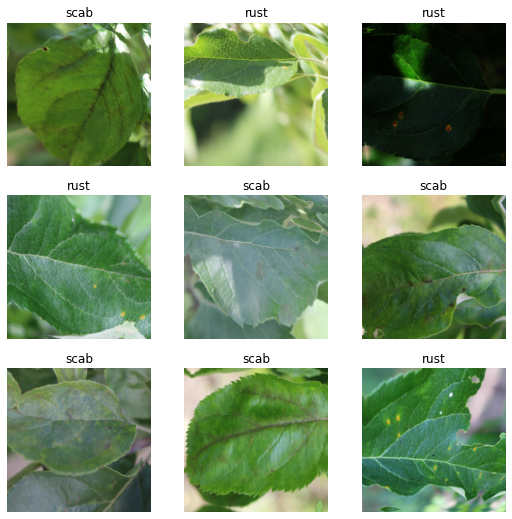

In [24]:
dls.show_batch()

### Metric

In [25]:
def comp_metric(preds, targs, labels=range(len(labels))):
  targs = np.eye(4)[targs]
  return np.mean([roc_auc_score(targs[:,i], preds[:, i]) for i in labels])

def healthy_roc_auc(*args):
  return comp_metric(*args, lables=[0])

def multiple_diseases_roc_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_roc_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_roc_auc(*args):
    return comp_metric(*args, labels=[3])

### Training

In [29]:
learn = cnn_learner(
    dls,
    resnet50,
    loss_func=LabelSmoothingCrossEntropy(),
    metrics=[accuracy, AccumMetric(comp_metric, flatten=False)]
).to_fp16()

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0008317637839354575)

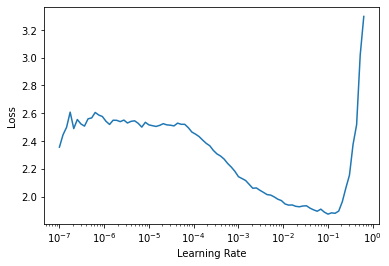

In [30]:
learn.lr_find()

In [31]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,1.298408,0.910307,0.817694,0.924554,02:43


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.851754,0.632004,0.923593,0.958651,02:46
1,0.677513,0.526729,0.950402,0.978625,02:46
2,0.552900,0.457188,0.969169,0.983915,02:46
3,0.512261,0.434218,0.981233,0.984581,02:46
4,0.474460,0.424169,0.979893,0.988223,02:46


In [33]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.484152,0.443362,0.982574,0.991972,02:44


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.472326,0.454599,0.959786,0.980627,02:47
1,0.495995,0.448608,0.963807,0.980271,02:47
2,0.451777,0.409623,0.982574,0.995772,02:46
3,0.422978,0.405638,0.983914,0.996994,02:46
4,0.411409,0.407183,0.987936,0.996674,02:47


In [34]:
learn.save('stage-2-fine_tune')

Path('models/stage-2-fine_tune.pth')

### Interpretation and Test

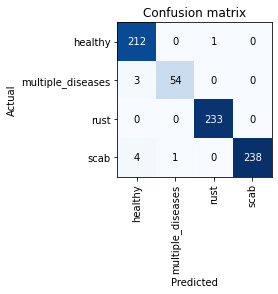

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

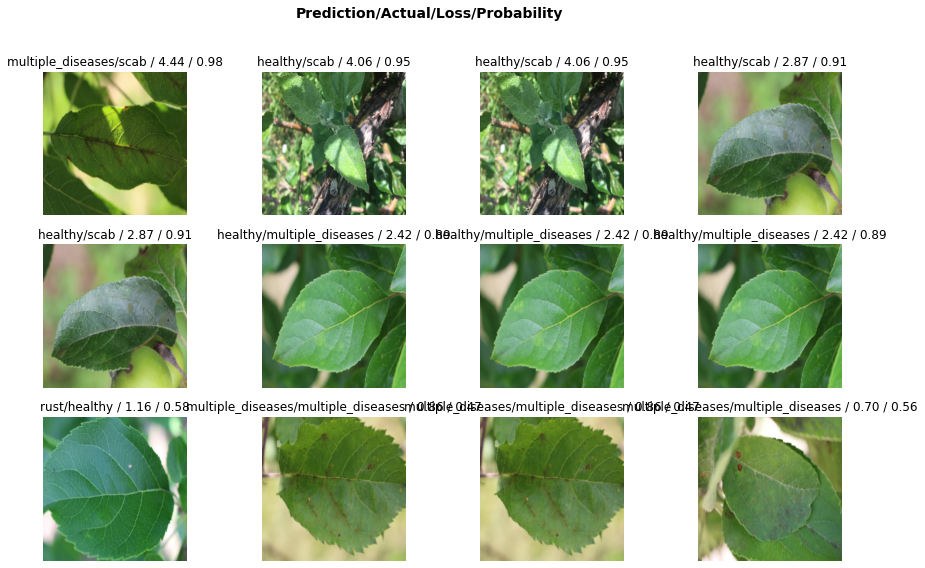

In [36]:
interp.plot_top_losses(12, figsize=(15,9), nrows=3)

In [37]:
test_df = pd.read_csv(data_dir/'test.csv')
test_dl = dls.test_dl(test_df)

In [38]:
test_preds, _ = learn.get_preds(dl=test_dl)

In [39]:
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=labels)], axis=1)
sub_df

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.023558,0.023765,0.938248,0.014429
1,Test_1,0.026902,0.020667,0.931805,0.020626
2,Test_2,0.011730,0.043604,0.006899,0.937767
3,Test_3,0.964816,0.010807,0.014367,0.010010
4,Test_4,0.021663,0.031274,0.928352,0.018711
...,...,...,...,...,...
1816,Test_1816,0.023827,0.028406,0.927898,0.019869
1817,Test_1817,0.219250,0.174226,0.052968,0.553555
1818,Test_1818,0.030336,0.011718,0.936372,0.021574
1819,Test_1819,0.953655,0.026818,0.005464,0.014062


### Submission

In [40]:
! pip uninstall -y kaggle
! pip install kaggle

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10
     |████████████████████████████████| 61kB 4.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=2d02e80073a2b5e8f5837cf2613aa5b0de319ceadac1eb74fb62f6e1b3c58804
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle


In [45]:
! mkdir ~/.kaggle

In [46]:
! ls ~ -a

.   .bash_history  .cache   .gsutil   .jupyter	.keras	.npm  .profile
..  .bashrc	   .config  .ipython  .kaggle	.local	.nv


In [47]:
! cp /content/drive/MyDrive/Kaggle/kaggle.json /root/.kaggle/

In [ ]:
!kaggle --version

Kaggle API 1.5.10


In [48]:
sub_df.to_csv('submission.csv', index=False)

In [49]:
! head -n 5 submission.csv

image_id,healthy,multiple_diseases,rust,scab
Test_0,0.023557505,0.023765465,0.9382484,0.014428566
Test_1,0.02690202,0.020666819,0.93180466,0.020626493
Test_2,0.011730051,0.043603707,0.0068991086,0.9377671
Test_3,0.96481586,0.010807475,0.014366599,0.010009932


In [50]:
! kaggle competitions submit plant-pathology-2020-fgvc7 -f submission.csv -m "resnet50-300px-fine-tune"

100% 97.5k/97.5k [00:02<00:00, 41.5kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7